In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import copy
import multiprocessing
import timeit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/epi_data_folders'
os.chdir(path)
!ls

MSEL_00095  MSEL_01097	    MSEL_01763	MSEL_01849	    start_end_new.csv
MSEL_00172  MSEL_01110-ICU  MSEL_01808	MSEL_01870
MSEL_00182  MSEL_01575	    MSEL_01828	rapidsai-csp-utils
MSEL_00501  MSEL_01676	    MSEL_01842	start_end.csv
MSEL_00502  MSEL_01709	    MSEL_01844	start_end.gsheet


In [ ]:
normalized = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_00182/normalized_data/00182_BVP.parquet")

In [ ]:
normalized

,time,BVP,BVP_normalized
0,1.564082e+12,-44921876.0,0.096500
1,1.564082e+12,-44921876.0,0.096500
2,1.564082e+12,-44921876.0,0.096500
3,1.564082e+12,-44921876.0,0.096500
4,1.564082e+12,-44921876.0,0.096500
...,...,...,...
39281995,1.564389e+12,88378904.0,0.096561
39281996,1.564389e+12,88378904.0,0.096561
39281997,1.564389e+12,88378904.0,0.096561
39281998,1.564389e+12,88378904.0,0.096561


In [ ]:
normalized.isnull().sum()

time                   0
BVP               350000
BVP_normalized    350000
dtype: int64

In [ ]:
# remove existing concat_data folders
for dir in os.listdir("./"):
  print(dir)
  if "MSEL" in dir and "concat_data" in os.listdir("./"+dir):
    folder = "./"+dir+"/concat_data"
    shutil.rmtree(folder)

MSEL_01575
MSEL_01828
MSEL_01709
MSEL_01870
MSEL_01842
MSEL_01844
MSEL_01097
MSEL_00182
MSEL_01676
MSEL_01849
MSEL_01808
MSEL_00501
MSEL_00172
MSEL_01763
MSEL_00502
MSEL_00095
MSEL_01110-ICU
start_end.csv
start_end.gsheet
rapidsai-csp-utils


In [ ]:
patients = ['MSEL_01575',
 'MSEL_01828',
 'MSEL_01709',
 'MSEL_01870',
 'MSEL_01842',
 'MSEL_01844',
 'MSEL_01097',
 'MSEL_00182',
 'MSEL_01676',
 'MSEL_01849',
 'MSEL_01808',
 'MSEL_00501',
 'MSEL_00172',
 'MSEL_01763',
 'MSEL_00502']

In [ ]:
patient_nums = []
for filename in patients:
  if "MSEL" in filename:
    patient_nums.append(filename[-5:])

In [ ]:
def concat(patient_num, channel_name):
  cur_dir = "/content/drive/My Drive/epi_data_folders/MSEL_{}/Empatica-{}".format(patient_num, channel_name)
  os.chdir(cur_dir)
  seg_num = !ls | wc -l 
  seg_num = int(seg_num[0])   # get the number of files in the folder
                   # the way it sorts the filename with numbers is "1", "11", "2"

  df_lsts = []
  for i in range(seg_num):
    filename = "MSEL_{}_Empatica-{}_{}_segment_{}.parquet".format(patient_num, channel_name, channel_name, i)
    df = pd.read_parquet(filename, engine="auto")
    if i != 0:
      pre = df_lsts[-1]["time"][df_lsts[-1].shape[0] - 1]
      next = df["time"][0]

      if next - pre != 7.8125:    # 128Hz corresponds to 7.8125ms
        gap = pd.DataFrame(np.arange(pre, next, 7.8125))    # generate a timestamp every 7.8125ms
        gap = gap.drop(0) 
        nan_col = np.empty((gap.shape[0],1)) 
        nan_col.fill(np.nan)
        combined = pd.DataFrame(np.c_[gap, nan_col])    # add a column of np.nan to the timestamp
        combined.rename({0: "time", 1: "data"}, axis = 1, inplace = True)
        df_lsts.append(combined)

    df_lsts.append(df)
  df_concat = pd.concat(df_lsts)
  df_concat.rename(columns = {"data": "{}".format(channel_name)}, inplace = True)
  df_concat.reset_index(inplace=True)
  df_concat.drop(columns=['index'], inplace=True)

  return df_concat

In [ ]:
def concat_forall(patient_num):
  for feature in ["BVP", "EDA", "HR", "TEMP"]:
    df_concat = concat(patient_num, feature)
    df_concat.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, feature))

In [ ]:
def concat_Acc(patient_num):
  cur_dir = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/Empatica-ACC".format(patient_num)
  os.chdir(cur_dir)
  seg_num = !ls | wc -l 
  seg_num = int(int(seg_num[0]) / 4) # get the number of files in the folder
                      # the way it sorts the filename with numbers is "1", "11", "2"

  for coordinate in ["Mag", "x", "y", "z"]:
    df_lsts = []
    for i in range(seg_num):
      filename = "MSEL_{}_Empatica-ACC_Acc {}_segment_{}.parquet".format(patient_num, coordinate, i)
      df = pd.read_parquet(filename, engine="auto")
      if i != 0:
        pre = df_lsts[-1]["time"][df_lsts[-1].shape[0] - 1]
        next = df["time"][0]

        if next - pre != 7.8125:    # 128Hz corresponds to 7.8125ms
          gap = pd.DataFrame(np.arange(pre, next, 7.8125))    # generate a timestamp every 7.8125ms
          gap = gap.drop(0) 
          nan_col = np.empty((gap.shape[0],1)) 
          nan_col.fill(np.nan)
          combined = pd.DataFrame(np.c_[gap, nan_col])    # add a column of np.nan to the timestamp
          combined.rename({0: "time", 1: "data"}, axis = 1, inplace = True)
          df_lsts.append(combined)
          
      df_lsts.append(df)
    df_concat = pd.concat(df_lsts)
    df_concat.rename(columns = {"data": "{}".format(coordinate)}, inplace = True)
    df_concat.reset_index(inplace=True)
    df_concat.drop(columns=['index'], inplace=True)
    df_concat.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, coordinate))

In [ ]:
patient_nums = []
for filename in os.listdir("/content/drive/MyDrive/epi_data_folders"):
  if "MSEL" in filename:
    patient_nums.append(filename[-5:])
for patient_num in patient_nums:
  concat_forall(patient_num)
  concat_Acc(patient_num)

FileNotFoundError: ignored

In [ ]:
for patient_num in patient_nums:
  path = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data".format(patient_num)
  os.mkdir(path)
  for signal in ["BVP", "EDA", "HR", "Mag", "TEMP", "x", "y", "z"]:
    shutil.move("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, signal), "/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data/{}_{}.parquet".format(patient_num, patient_num, signal))

FileNotFoundError: ignored

In [ ]:
def split_signal(patient_num, signal):
  df_split = pd.read_csv("/content/drive/MyDrive/epi_data_folders/MSEL_{}/MSEL_{}_labels_split.csv".format(patient_num, patient_num))
  df_concat = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, signal))

  folder = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}".format(patient_num, signal)
  if "{}".format(signal) in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)):
    shutil.rmtree(folder)
  os.mkdir(folder)

  cur_seg = 0

  for i in range(df_split.shape[0]):
    print("**********segment*********", i)
    print(cur_seg)
    cur_seg += round((df_split.iloc[i]["label_start_time"] - df_concat.iloc[cur_seg]["time"]) // 7.8125)
    print(cur_seg)
    exit(1)
    while cur_seg < df_concat.shape[0]:
      if df_concat.iloc[cur_seg]["time"] - 7.8125 < df_split.iloc[i]["label_start_time"] <= df_concat.iloc[cur_seg]["time"]:
        start_index = cur_seg
        cur_seg += 6
        while cur_seg < df_concat.shape[0]:
          if df_concat.iloc[cur_seg]["time"] >= df_split.iloc[i]["label_start_time"] + 60 * 1000:
            end_index = cur_seg - 1
            break
          cur_seg += 1
        print("start:", df_concat.iloc[start_index]["time"])
        print("end:", df_concat.iloc[end_index]["time"])
        new_seg = df_concat.iloc[start_index:end_index].to_numpy()
        # np.save("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}/segment{}".format(patient_num, signal, i), new_seg)
        df_concat.iloc[start_index:end_index].to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}/segment{}.parquet".format(patient_num, signal, i))
        break
      cur_seg += 1
      print(cur_seg)


In [ ]:
def split(patient_num):
  
  path = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)
  if "segments" in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}".format(patient_num)):
    shutil.rmtree(path)
  os.mkdir(path)

  for signal in ["BVP", "EDA", "HR", "Mag", "TEMP", "x", "y", "z"]:
    split_signal(patient_num, signal)

In [ ]:
a_pool = multiprocessing.Pool()

result = a_pool.map(split, ["01763", "01808", "01844"])

print(result)

Streaming output truncated to the last 5000 lines.
start: 1557580119000.0
end: 1557580178992.1875
**********segment********* 17
29623424
29623424
start: 1558765184000.0
end: 1558765243992.1875
**********segment********* 95
26394368
26394368
start: 1557580179000.0
end: 1557580238992.1875
**********segment********* 18
29631104
29631104
start: 1558765244000.0
end: 1558765303992.1875
**********segment********* 96
26402048
26402048
start: 1557580239000.0
end: 1557580298992.1875
**********segment********* 19
29638784
29638784
start: 1558765304000.0
end: 1558765363992.1875
**********segment********* 97
26409728
26409728
start: 1557580299000.0
end: 1557580358992.1875
**********segment********* 20
29646464
29646464
start: 1558765364000.0
end: 1558765423992.1875
**********segment********* 98
26417408
26417408
start: 1557580359000.0
end: 1557580418992.1875
**********segment********* 21
29654144
29654144
start: 1558765424000.0
end: 1558765483992.1875
**********segment********* 99
26425088
26425088

In [ ]:
split_signal("00172", "z")

Streaming output truncated to the last 5000 lines.
**********segment********* 2044
24033792
24033792
start: 1556495532000.0
end: 1556495591992.1875
**********segment********* 2045
24041472
24041472
start: 1556495592000.0
end: 1556495651992.1875
**********segment********* 2046
24049152
24049152
start: 1556495652000.0
end: 1556495711992.1875
**********segment********* 2047
24056832
24056832
start: 1556495712000.0
end: 1556495771992.1875
**********segment********* 2048
24064512
24064512
start: 1556495772000.0
end: 1556495831992.1875
**********segment********* 2049
24072192
24072192
start: 1556495832000.0
end: 1556495891992.1875
**********segment********* 2050
24079872
24079872
start: 1556495892000.0
end: 1556495951992.1875
**********segment********* 2051
24087552
24087552
start: 1556495952000.0
end: 1556496011992.1875
**********segment********* 2052
24095232
24095232
start: 1556496012000.0
end: 1556496071992.1875
**********segment********* 2053
24102912
24102912
start: 1556496072000.0
end

In [ ]:
# for patient_num in patient_nums:
patient_num = "00502"
signal = "BVP"
df_split = pd.read_csv("/content/drive/MyDrive/epi_data_folders/MSEL_{}/MSEL_{}_labels_split.csv".format(patient_num, patient_num))
df_concat = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, signal))
folder = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}".format(patient_num, signal)
if "{}".format(signal) in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)):
  shutil.rmtree(folder)
os.mkdir(folder)
cur_seg = 0
i = 0
cur_seg += round((df_split.iloc[i]["label_start_time"] - df_concat.iloc[cur_seg]["time"]) // 7.8125)
print(df_split.iloc[i]["label_start_time"])
print(df_concat.iloc[cur_seg]["time"])
# while cur_seg < df_concat.shape[0]:
#   if df_concat.iloc[cur_seg]["time"] - 7.8125 < df_split.iloc[i]["label_start_time"] <= df_concat.iloc[cur_seg]["time"]:
#     start_index = cur_seg
#     cur_seg += 6
#     while cur_seg < df_concat.shape[0]:
#       if df_concat.iloc[cur_seg]["time"] >= df_split.iloc[i]["label_start_time"] + 60 * 1000:
#         end_index = cur_seg - 1
#         break
#       cur_seg += 1

1551516063000
1551689352062.5


In [ ]:
round(1.34)

1

In [ ]:
df_concat

,time,BVP,BVP_normalized
0,1.551533e+12,142578128.0,-0.064838
1,1.551533e+12,142578128.0,-0.064838
2,1.551533e+12,142578128.0,-0.064838
3,1.551533e+12,142578128.0,-0.064838
4,1.551533e+12,142578128.0,-0.064838
...,...,...,...
22180995,1.551706e+12,142578128.0,-0.064838
22180996,1.551706e+12,142578128.0,-0.064838
22180997,1.551706e+12,142578128.0,-0.064838
22180998,1.551706e+12,142578128.0,-0.064838


In [ ]:
# for i in range(21):
#   if df_concat.iloc[(i+1) * 1000000]["time"] - df_concat.iloc[i * 1000000]["time"] != 1000000 * 7.8125:
#     print(i)
if df_concat.iloc[22180999]["time"] - df_concat.iloc[22000000]["time"] == 180999 * 7.8125:
  print("twrsgdfb")

twrsgdfb


In [ ]:
for i in range(df_concat.shape[0] - 1):
  if i % 1000 == 0:
    print(i)
  if df_concat.iloc[i+1]["time"] - df_concat.iloc[i]["time"] != 7.8125:
    print("**********")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


KeyboardInterrupt: ignored

In [ ]:
df_split

,label,name,study_start_time,study_duration,label_start_time,label_duration,label_note
0,1,MSEL_00182,1564081653000,306901000,1564206307000,60000,"""hypermotor - Starting anterior to the prior r..."
1,1,MSEL_00182,1564081653000,306901000,1564206367000,60000,"""hypermotor - Starting anterior to the prior r..."
2,2,MSEL_00182,1564081653000,306901000,1564213627000,60000,"Interictal - ""hypermotor - Starting anterior t..."
3,2,MSEL_00182,1564081653000,306901000,1564213687000,60000,"Interictal - ""hypermotor - Starting anterior t..."
4,2,MSEL_00182,1564081653000,306901000,1564213747000,60000,"Interictal - ""hypermotor - Starting anterior t..."
...,...,...,...,...,...,...,...
1301,0,MSEL_00182,1564081653000,306901000,1564296127000,60000,"Preictal - ""hypermotor - Starting anterior to ..."
1302,0,MSEL_00182,1564081653000,306901000,1564296187000,60000,"Preictal - ""hypermotor - Starting anterior to ..."
1303,0,MSEL_00182,1564081653000,306901000,1564296247000,60000,"Preictal - ""hypermotor - Starting anterior to ..."
1304,1,MSEL_00182,1564081653000,306901000,1564297207000,60000,"""hypermotor - Starting anterior to the prior r..."


In [ ]:
df.BVP.isnull().sum()

350000

In [ ]:
df.interpolate('spline', order=3, inplace = True)

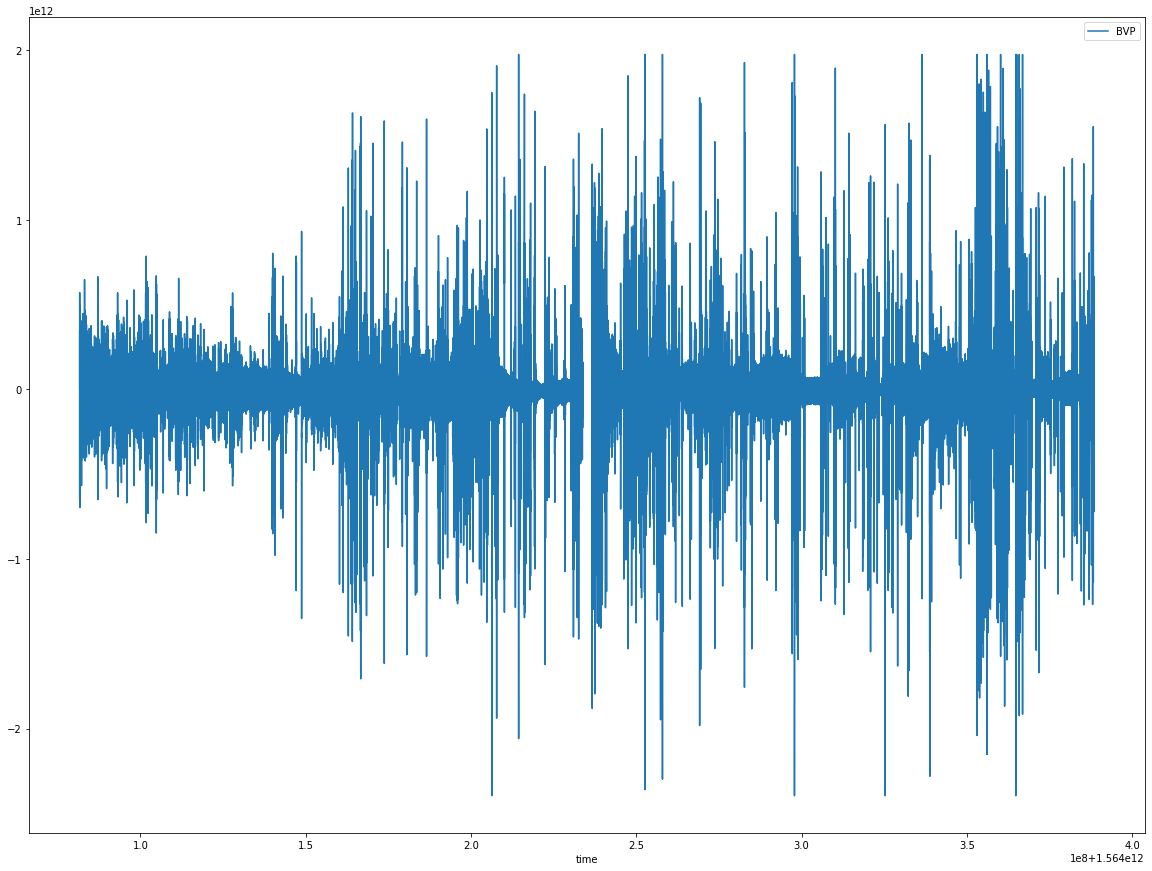

In [ ]:
df.plot(x = "time", y = "BVP", figsize = (20, 15))

In [ ]:
os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_01575")

['Empatica-HR',
 'Empatica-ACC',
 'Empatica-BVP',
 'Empatica-EDA',
 'Empatica-TEMP',
 'MSEL_01575_Empatica-ACC_Acc Mag_metadata.csv',
 'MSEL_01575_Empatica-HR_HR_metadata.csv',
 'MSEL_01575_labels.csv',
 'MSEL_01575_Empatica-ACC_Acc y_metadata.csv',
 'MSEL_01575_Empatica-ACC_Acc x_metadata.csv',
 'MSEL_01575_Empatica-EDA_EDA_metadata.csv',
 'MSEL_01575_Empatica-BVP_BVP_metadata.csv',
 'MSEL_01575_Empatica-TEMP_TEMP_metadata.csv',
 'MSEL_01575_Empatica-ACC_Acc z_metadata.csv',
 'concat_data',
 'MSEL_01575_labels_new.csv']

In [ ]:
def print_gaps_feature(patient_num, feature):
  df = pd.read_csv("/content/drive/My Drive/epi_data_folders/MSEL_{}/MSEL_{}_Empatica-{}_{}_metadata.csv".format(patient_num, patient_num, feature, feature))
  print("**********{}_{}**********".format(patient_num, feature))
  count = 0
  for i in range(df.shape[0] - 1):
    if df["segments.duration"][i] + df["segments.startTime"][i] != df["segments.startTime"][i + 1]:
      count += 1
  print(count)
  # for i in range(df.shape[0] - 1):
  #   if df["segments.duration"][i] + df["segments.startTime"][i] != df["segments.startTime"][i + 1]:
  #     print("row:", i)
  #     print("first segment starttime:", df["segments.startTime"][i])
  #     print("first segment duration:", df["segments.duration"][i])
  #     print("first segment endtime:", df["segments.startTime"][i] + df["segments.duration"][i])
  #     print("second segment starttime:", df["segments.startTime"][i + 1])
  #     print("interval:", df["segments.startTime"][i + 1] - df["segments.startTime"][i] - df["segments.duration"][i])

In [ ]:
concatenated_patients = ['MSEL_01575',
              'MSEL_01828',
              'MSEL_01709',
              'MSEL_01870',
              'MSEL_01842',
              'MSEL_01844',
              'MSEL_01097',
              'MSEL_00182',
              'MSEL_01676',
              'MSEL_01849',
              'MSEL_01808',
              'MSEL_00501',
              'MSEL_00172',
              'MSEL_01763',
              'MSEL_00502']
concatenated_patient_nums = [patient[-5:] for patient in concatenated_patients]
concatenated_patient_nums

['01575',
 '01828',
 '01709',
 '01870',
 '01842',
 '01844',
 '01097',
 '00182',
 '01676',
 '01849',
 '01808',
 '00501',
 '00172',
 '01763',
 '00502']

In [ ]:
patient_lst = []
start = []
end = []
for patient_num in concatenated_patient_nums:
  # print("patient_num", patient_num)
  starttime = 0
  finishtime = math.inf
  for signal in ["BVP", "EDA", "HR", "TEMP", "Mag", "x", "y", "z"]:
    df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data/{}_{}.parquet".format(patient_num, patient_num, signal))
    new_starttime = df["time"][0]
    # print(new_starttime)
    if new_starttime > starttime:
      starttime = new_starttime
    new_finishtime = df["time"][df.shape[0] - 1]
    # print(new_finishtime)
    if new_finishtime < finishtime:
      finishtime = new_finishtime
    # print("starttime: ", starttime)
    # print("finishtime: ",finishtime)
  # for signal in ["Mag", "x", "y", "z"]:
  #   df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data/{}_{}.to_parquet".format(patient_num, patient_num, signal))
  #   new_starttime = df["time"][0]
  #   print(new_starttime)
  #   if new_starttime > starttime:
  #     starttime = new_starttime
  #   new_finishtime = df["time"][df.shape[0] - 1]
  #   print(new_finishtime)
  #   if new_finishtime < finishtime:
  #     finishtime = new_finishtime
  #   # print("starttime: ", starttime)
  #   # print("finishtime: ",finishtime)
  patient_lst.append(patient_num)
  start.append(starttime)
  end.append(finishtime)
  df = pd.DataFrame(list(zip(patient_lst, start, end)), columns =['patient_num', 'start', "end"])
  df.to_csv("/content/drive/MyDrive/epi_data_folders/start_end_new.csv")

In [ ]:
def print_gaps(patient_num):
  for feature in ["HR", "EDA", "BVP", "TEMP"]:
    df = pd.read_csv("/content/drive/My Drive/epi_data_folders/MSEL_{}/MSEL_{}_Empatica-{}_{}_metadata.csv".format(patient_num, patient_num, feature, feature))
    # print("**********{}_{}**********".format(patient_num, feature))
    for i in range(df.shape[0] - 1):
      if df["segments.duration"][i] + df["segments.startTime"][i] != df["segments.startTime"][i + 1]:
        print("row:", i)
        print("first segment starttime:", df["segments.startTime"][i])
        print("first segment duration:", df["segments.duration"][i])
        print("first segment endtime:", df["segments.startTime"][i] + df["segments.duration"][i])
        print("second segment starttime:", df["segments.startTime"][i + 1])
        print("interval:", df["segments.startTime"][i + 1] - df["segments.startTime"][i] - df["segments.duration"][i])

# print_gaps("00182")



In [ ]:
Mag = pd.read_csv("/content/drive/MyDrive/epi_data_folders/MSEL_00172/MSEL_00172_Empatica-BVP_BVP_metadata.csv")

for i in range(Mag.shape[0] - 1):
  if Mag["segments.duration"][i] + Mag["segments.startTime"][i] != Mag["segments.startTime"][i + 1]:
    print("row:", i)
    print("first segment starttime:", Mag["segments.startTime"][i])
    print("first segment duration:", Mag["segments.duration"][i])
    print("first segment endtime:", Mag["segments.startTime"][i] + Mag["segments.duration"][i])
    print("second segment starttime:", Mag["segments.startTime"][i + 1])
    print("interval:", Mag["segments.startTime"][i + 1] - Mag["segments.startTime"][i] - Mag["segments.duration"][i])

row: 44
first segment starttime: 1556465893000.0
first segment duration: 46875.0
first segment endtime: 1556465939875.0
second segment starttime: 1556466001000.0
interval: 61125.0


In [ ]:
os.listdir("/content/drive/MyDrive/epi_data_folders")

['MSEL_01575',
 'MSEL_01828',
 'MSEL_01709',
 'MSEL_01870',
 'MSEL_01842',
 'MSEL_01844',
 'MSEL_01097',
 'MSEL_00182',
 'MSEL_01676',
 'MSEL_01849',
 'MSEL_01808',
 'MSEL_00501',
 'MSEL_00172',
 'MSEL_01763',
 'MSEL_00502']

In [ ]:
from datetime import datetime
datetime.fromtimestamp(1564081654)

datetime.datetime(2019, 7, 25, 19, 7, 34)